# Análise Dados - Concerta 1ª Formação

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
from sklearn_extra.cluster import KMedoids
import matplotlib.colors as mcolors
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import cv2
os.environ["LOKY_MAX_CPU_COUNT"] = "4" # Evitar erro de memória no KMeans


## Ler o Dataframe

In [3]:
# Ler o csv 'concerta_2024-09-19.csv'
data = pd.read_csv('Data/concerta_2024-09-19.csv')
print("Valores iniciais: " + str(data.shape))

data.head(2)

Valores iniciais: (429949, 11)


,time,ad_displayed,emotion,engaged,face_x1y1x2y2_coordinates,gender,person,race,source,age,head_position
0,2024-09-19 14:59:59.516000+00:00,young_male,neutral,yes,"(698, 804, 788, 934)",female,3364,white,1,15,"(5.903427, 0.48050785, 11.568752)"
1,2024-09-19 14:59:59.516000+00:00,young_male,anger,yes,"(1465, 776, 1562, 891)",female,3516,white,1,25,"(22.450283, -0.5638857, 3.3841372)"


In [4]:
print(data.dtypes)

time                         object
ad_displayed                 object
emotion                      object
engaged                      object
face_x1y1x2y2_coordinates    object
gender                       object
person                        int64
race                         object
source                        int64
age                           int64
head_position                object
dtype: object


## Adaptar Colunas

In [5]:
# Ajustar o nome das colunas da posição da face
# data['face_x1y1x2y2_coordinates'] = list(zip(data['face_bbox_x1'], data['face_bbox_y1'], data['face_bbox_x2'], data['face_bbox_y2']))
# data = data.drop(['face_bbox_x1', 'face_bbox_y1', 'face_bbox_x2', 'face_bbox_y2'], axis=1)

# Ajustar o nome das colunas da posição da head_position
# data['head_position'] = list(zip(data['head_yaw'], data['head_pitch'], data['head_roll']))
# data = data.drop(['head_yaw', 'head_pitch', 'head_roll'], axis=1)

# ---- Depois mudar o nome da coluna person para face !!!!!!


## Limitar Intervalo de Horas DataFrame

In [6]:
# Adicionar coluna da hora para depois remover as horas que não são necessárias analisar
data['time'] = pd.to_datetime(data['time'], format='mixed')
data['hour'] = data['time'].dt.hour

#Remover dados antes das 9:00 e após as 12:00
data = data.drop(data.loc[(data['hour']<9) | (data['hour']>11)].index)

# Verificar os valores únicos da coluna 'hour'
print("Horas presentens no dataframe: " + str(data['hour'].unique()))

# Remover a coluna 'hour' já que não é mais necessária
data = data.drop(columns=['hour'])

Horas presentens no dataframe: [11 10  9]


## Remover "Trash Values" e Outliers

#### Valores nulos e missing values

In [7]:
## Verificar valores nulos
print("Valores nulos: " + str(data.isnull().sum().sum()))
# Verificar missing values
print("Missing values: " + str(data.isna().sum().sum()))


Valores nulos: 0
Missing values: 0


#### Coluna 'age'

In [8]:
# Verificar a quantidade de dados para cada valor da coluna 'age'
for i in data['age'].unique():
    print(str(i) + ": " + str(data[data['age'] == i].shape[0]))

# Remover outliers da coluna 'age'
data = data.drop(data.loc[(data['age'] == 1) | (data['age'] == 5) | (data['age'] == 55)].index)

25: 87827
15: 42531
5: 3665
35: 43573
45: 2433
1: 41
55: 8


#### Coluna 'gender'

In [9]:
# Verificar valores da coluna 'gender'
print(data['gender'].value_counts())

gender
male      118880
female     57484
Name: count, dtype: int64


In [10]:
# Verificar diferentes valores de idade para os diferentes géneros
print(data.groupby(['age', 'gender']).size())

# Remover valores para 'female' com 45 anos
data = data.drop(data.loc[(data['age'] == 45) & (data['gender'] == 'female')].index)


age  gender
15   female    24828
     male      17703
25   female    31583
     male      56244
35   female     1017
     male      42556
45   female       56
     male       2377
dtype: int64


#### Coluna 'emotion'

In [11]:
# Contagem dos valores da coluna 'emotion'
print(data['emotion'].value_counts())

#Remover valores 'unknown' da coluna 'emotion'
data = data.drop(data.loc[data['emotion'] == 'unknown'].index)

emotion
neutral     130905
sad          19332
surprise     10243
anger         7623
unknown       4579
happy         3626
Name: count, dtype: int64


#### Coluna 'ad_displayed'

In [12]:
# Verificar quais valores da coluna 'ad_displayed'
print(data['ad_displayed'].value_counts())

# Remover valores 'img_nexi' da coluna 'ad_displayed'
data = data.drop(data.loc[data['ad_displayed'] == 'img_nexi'].index)

ad_displayed
young_male      155385
young_female     16148
old_male           177
img_nexi            19
Name: count, dtype: int64


#### Coluna 'race'

In [13]:
# Verificar quais valores na coluna 'race'
print(data['race'].value_counts())

# Remover valores 'black' e 'southeast_asian' da coluna 'race'
data = data.drop(data.loc[(data['race'] == 'black') | (data['race'] == 'southeast_asian')].index)

race
white              124090
middle_eastern      33575
latino_hispanic      6166
east_asian           3938
indian               3183
black                 704
southeast_asian        54
Name: count, dtype: int64


#### Coluna 'face_x1y1x2y2_coordinates'

In [14]:
print(data['source'].value_counts())

# Calcular o centro da face dados 2 pontos (x1, y1) e (x2, y2)
def calcular_centro(coord_str):
    x1, y1, x2, y2 = ast.literal_eval(coord_str)
    centro_x = (x1 + x2) / 2
    centro_y = (y1 + y2) / 2
    return (centro_x, centro_y)

# Acrescentar uma feature que calcula o centro da cara
data['face'] = data['face_x1y1x2y2_coordinates'].apply(calcular_centro)

# Extrair os valores de x e y da coluna 'face'
x_coords = data['face'].apply(lambda coord: coord[0])  # Coordenadas x dos centros
y_coords = data['face'].apply(lambda coord: coord[1])  # Coordenadas y dos centros



source
0    122020
1     48932
Name: count, dtype: int64


##### Câmara superior (source == 1)

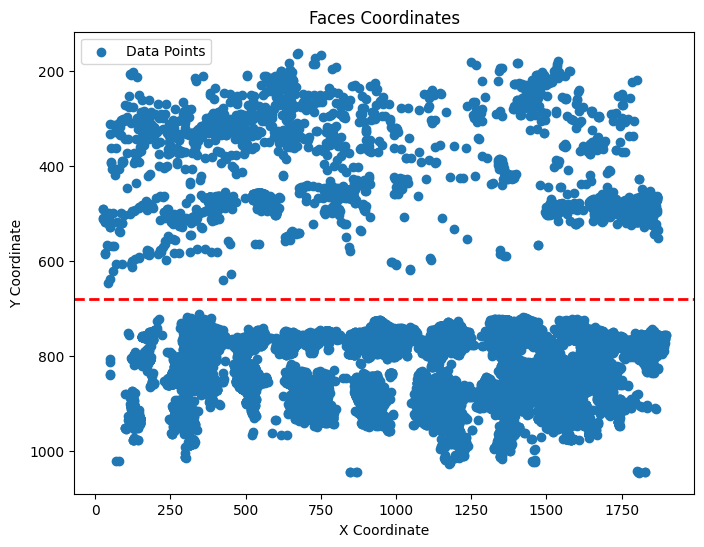

In [15]:
# Apenas dados da câmara superior (source = 1) 
filtered_data_1 = data.loc[data['source'] == 1]

# Criar o DataFrame 'coordinates' apenas com as coordenadas das faces filtradas
coordinates1 = pd.DataFrame(filtered_data_1['face'].tolist(), columns=['x', 'y'])

# Representar as coordenadas das faces
plt.figure(figsize=(8, 6))
plt.scatter(coordinates1['x'], coordinates1['y'], label='Data Points')
plt.axhline(680, color='red', linestyle='--', linewidth=2)
plt.title('Faces Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.gca().invert_yaxis()  # Inverter o eixo y
plt.show()

# Remover 'trash values' que possuem a coordenada Y < 650
data = data.drop(data.loc[(data['face'].apply(lambda coord: coord[1] < 680)) & (data['source'] == 1)].index)


##### Câmara inferior (source == 0)

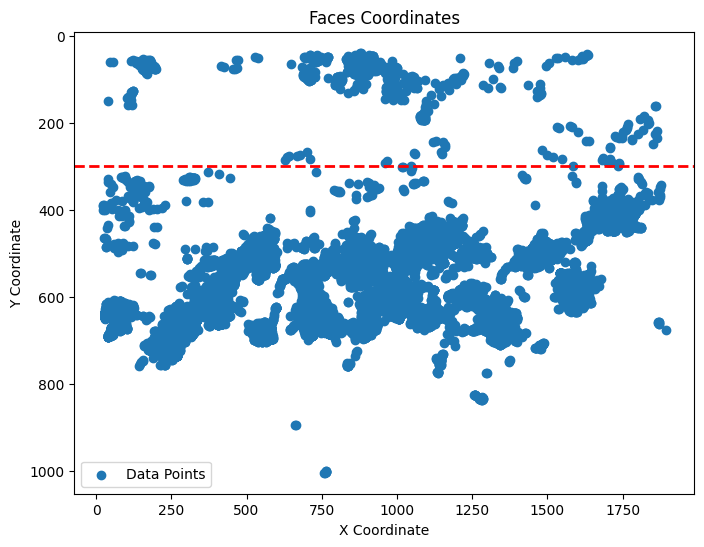

In [13]:
# Apenas dados da câmara superior (source = 1) 
filtered_data_0 = data.loc[data['source'] == 0]

# Criar o DataFrame 'coordinates' apenas com as coordenadas das faces filtradas
coordinates0 = pd.DataFrame(filtered_data_0['face'].tolist(), columns=['x', 'y'])



# Representar as coordenadas das faces
plt.figure(figsize=(8, 6))
plt.scatter(coordinates0['x'], coordinates0['y'], label='Data Points')
plt.axhline(300, color='red', linestyle='--', linewidth=2)
plt.title('Faces Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.gca().invert_yaxis()  # Inverter o eixo y
plt.show()

# Remover 'trash values' que possuem a coordenada Y < 650
data = data.drop(data.loc[(data['face'].apply(lambda coord: coord[1] < 300)) & (data['source'] == 0)].index)

## Analisar Dados

#### Calcular o 'Engagement'

In [14]:
# Função para calcular o Engagement
# Nesta função definimos o valor 35º para cada lado como o limite para considerar que a pessoa está a olhar para o ecrã
def looking_by_head_pose(pose):
    if (pose[1] > -35) & (pose[1] < 35) & (pose[2] > -35) & (pose[2] < 35) :
        return "yes"
    else:
        return "no"
   
data['engaged'] = data['head_position'].apply(lambda x: looking_by_head_pose(eval(x)))

teste = list(data['engaged'].value_counts())
print("Engaged: " + str(teste[0]))
print("Not Engaged: " + str(teste[1]))


Engaged: 145463
Not Engaged: 22177


## Distribuição do 'Engagement'

Engaged: 145463 (86.77%)
Not Engaged: 22177 (13.23%)


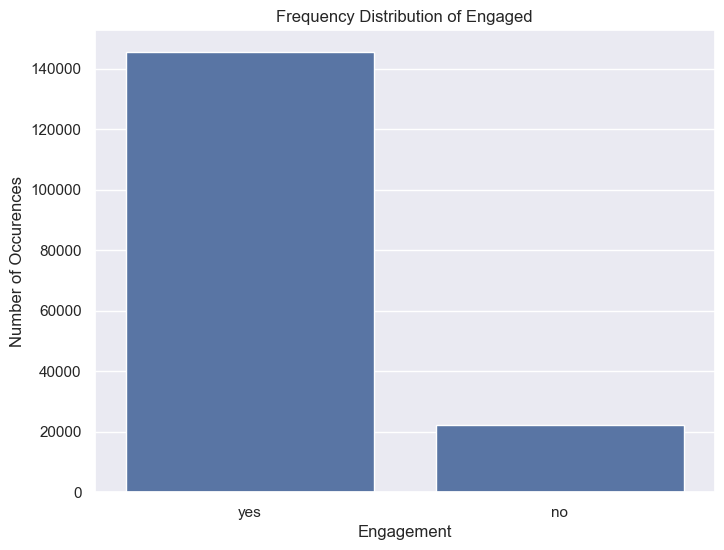

In [15]:
# Distribuição do Engagement
engagement_count = data['engaged'].value_counts()

# Plot da distribuição do Engagement
print("Engaged: " + str(engagement_count.iloc[0]) + " (" + str(round((engagement_count.iloc[0] / data.shape[0]) * 100, 2)) + "%)")
print("Not Engaged: " + str(engagement_count.iloc[1]) + " (" + str(round((engagement_count.iloc[1] / data.shape[0]) * 100, 2)) + "%)")

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.barplot(x=engagement_count.index, y=engagement_count.values)
plt.title('Frequency Distribution of Engaged')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Engagement', fontsize=12)
plt.show()

### 'Engagement' pelo Género

##### Male

Engaged (Male): 97918 (86.77%)
Not Engaged (Male): 14925 (13.23%)


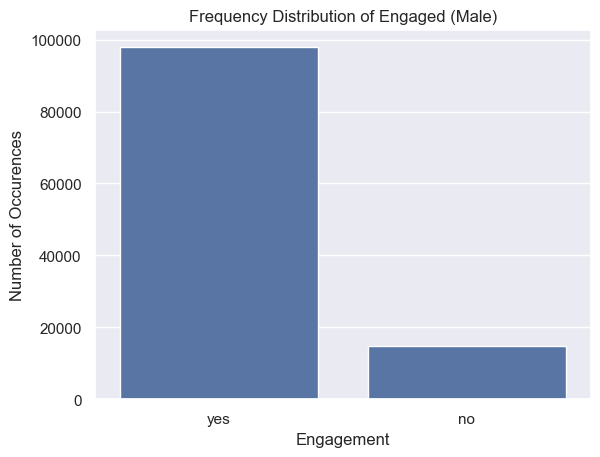

In [16]:
# Separar o dataframe nos 2 géneros
data_male = data.drop(data.loc[(data['gender'] == "female")].index).copy()

# Distribuição do 'Engagement' para o género masculino
engagement_count_male = data_male['engaged'].value_counts()


# Plot da distribuição do Engagement
print("Engaged (Male): " + str(engagement_count_male.iloc[0]) + " (" + str(round((engagement_count_male.iloc[0] / data_male.shape[0]) * 100, 2)) + "%)")
print("Not Engaged (Male): " + str(engagement_count_male.iloc[1]) + " (" + str(round((engagement_count_male.iloc[1] / data_male.shape[0]) * 100, 2)) + "%)")

sns.set_theme(style="darkgrid")
sns.barplot(x=engagement_count_male.index, y=engagement_count_male.values)
plt.title('Frequency Distribution of Engaged (Male)')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Engagement', fontsize=12)
plt.show()


##### Female

Engaged (Female): 47545 (86.77%)
Not Engaged (Female): 7252 (13.23%)


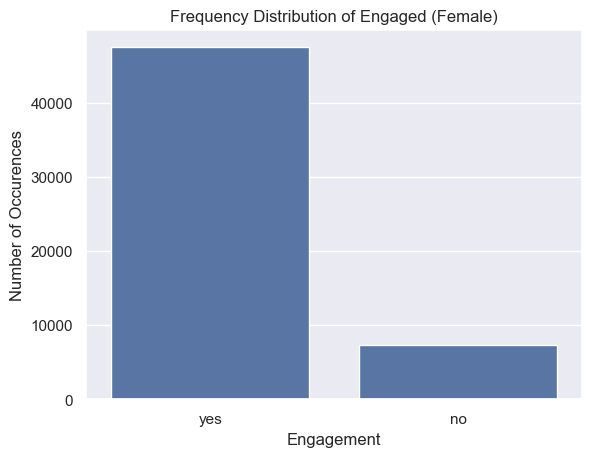

In [17]:
# Separar o dataframe nos 2 géneros
data_female = data.drop(data.loc[(data['gender'] == "male")].index).copy()

# Distribuição do 'Engagement' para o género masculino
engagement_count_female = data_female['engaged'].value_counts()


# Plot da distribuição do Engagement
print("Engaged (Female): " + str(engagement_count_female.iloc[0]) + " (" + str(round((engagement_count_female.iloc[0] / data_female.shape[0]) * 100, 2)) + "%)")
print("Not Engaged (Female): " + str(engagement_count_female.iloc[1]) + " (" + str(round((engagement_count_female.iloc[1] / data_female.shape[0]) * 100, 2)) + "%)")

sns.set_theme(style="darkgrid")
sns.barplot(x=engagement_count_female.index, y=engagement_count_female.values)
plt.title('Frequency Distribution of Engaged (Female)')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Engagement', fontsize=12)
plt.show()

### 'Engagement' pela Idade

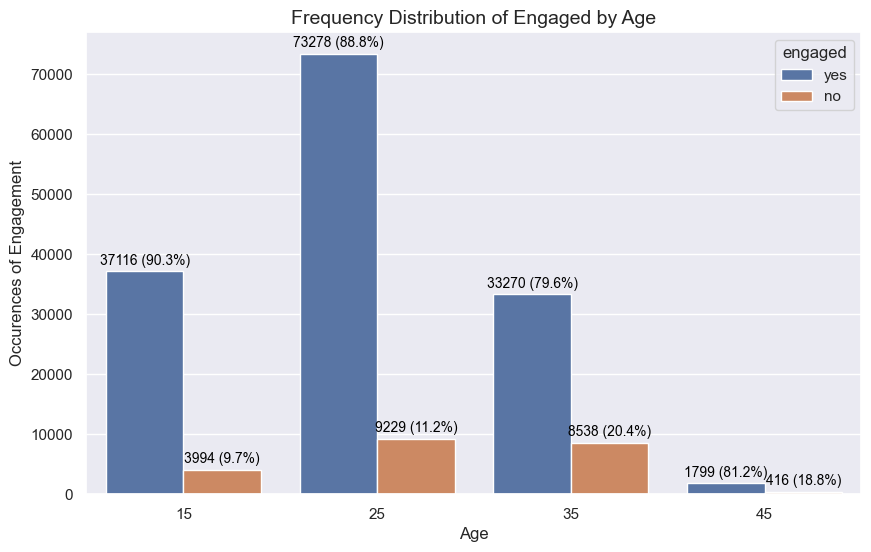

In [18]:
# Agrupar por idade e engagement, contando o número de ocorrências
engagement_by_age = data.groupby(['age', 'engaged']).size().reset_index(name='contagem')

# Calcular o total de ocorrências por idade
total_counts = list(engagement_by_age.groupby('age')['contagem'].sum()) * 2

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='age', y='contagem', hue='engaged', data=engagement_by_age,hue_order=['yes', 'no'])


# Adicionar os valores em cima de cada barra
for index, p in enumerate(ax.patches):
    if p.get_height() > 0:
        total_count = total_counts[index]
        ax.annotate(f'{int(p.get_height())} ({(p.get_height() / total_count) * 100:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Definir os títulos e rótulos
plt.title('Frequency Distribution of Engaged by Age', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Occurences of Engagement', fontsize=12)

# Mostrar o gráfico
plt.show()



### 'Engagement' pela Idade e Género

##### Male

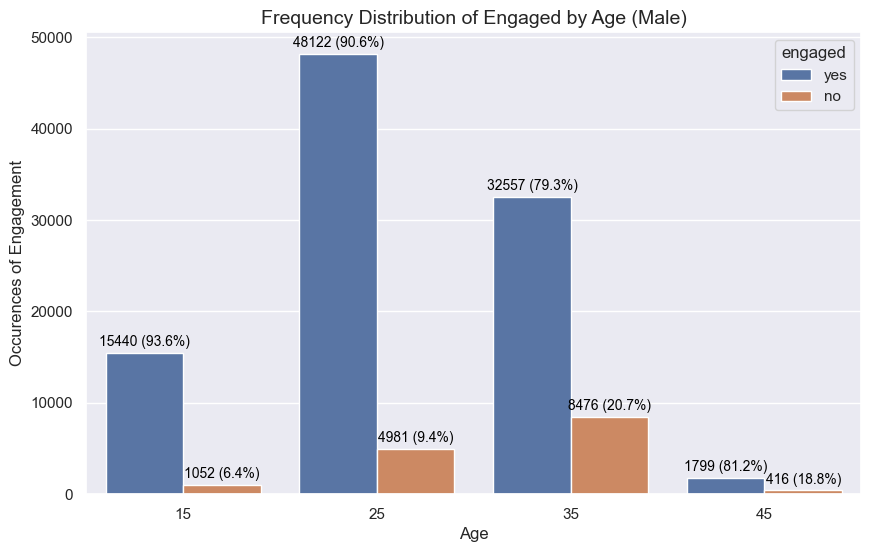

In [19]:
# Filtrar apenas as linhas onde o gênero é "male"
data_male = data.loc[data['gender'] == 'male'].copy()
engagement_by_age_male = data_male.groupby(['age', 'engaged']).size().reset_index(name='contagem')
total_counts = list(engagement_by_age_male.groupby('age')['contagem'].sum()) * 2



# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='age', y='contagem', hue='engaged', data=engagement_by_age_male, hue_order=['yes', 'no'])

# Adicionar os valores em cima de cada barra
for index, p in enumerate(ax.patches):
    if p.get_height() > 0:
        total_count = total_counts[index]
        ax.annotate(f'{int(p.get_height())} ({(p.get_height() / total_count) * 100:.1f}%)', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='baseline', 
            fontsize=10, color='black', xytext=(0, 5), 
            textcoords='offset points')

# Definir os títulos e rótulos
plt.title('Frequency Distribution of Engaged by Age (Male)', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Occurences of Engagement', fontsize=12)

# Mostrar o gráfico
plt.show()



##### Female

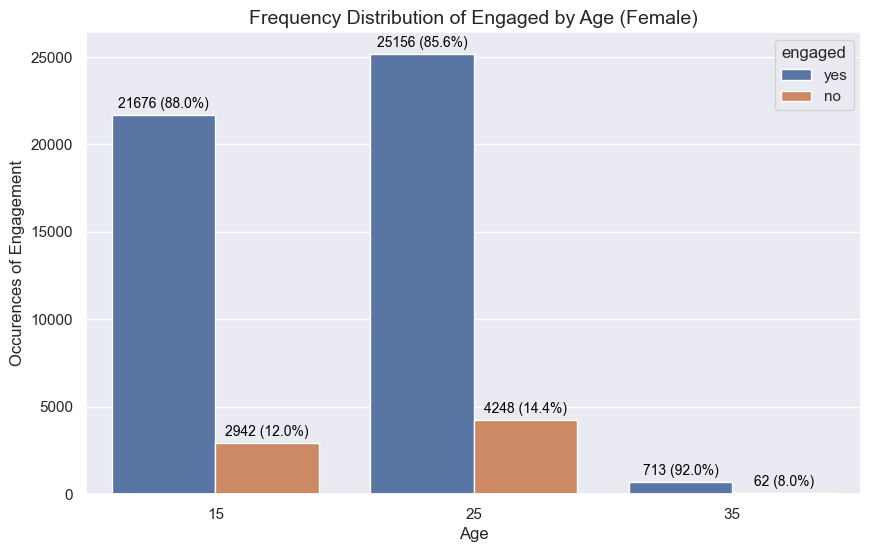

In [20]:
# Filtrar apenas as linhas onde o gênero é "female"
data_female = data.loc[data['gender'] == 'female'].copy()
engagement_by_age_female = data_female.groupby(['age', 'engaged']).size().reset_index(name='contagem')
total_counts = list(engagement_by_age_female.groupby('age')['contagem'].sum()) * 2



# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='age', y='contagem', hue='engaged', data=engagement_by_age_female, hue_order=['yes', 'no'])

# Adicionar os valores em cima de cada barra
for index, p in enumerate(ax.patches):
    if p.get_height() > 0:
        total_count = total_counts[index]
        ax.annotate(f'{int(p.get_height())} ({(p.get_height() / total_count) * 100:.1f}%)', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='baseline', 
            fontsize=10, color='black', xytext=(0, 5), 
            textcoords='offset points')

# Definir os títulos e rótulos
plt.title('Frequency Distribution of Engaged by Age (Female)', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Occurences of Engagement', fontsize=12)

# Mostrar o gráfico
plt.show()

## Distribuição das Emoções

neutral: 127809 (76.24%)
sad: 19026 (11.35%)
anger: 7444 (4.44%)
surprise: 9910 (5.91%)
happy: 3451 (2.06%)


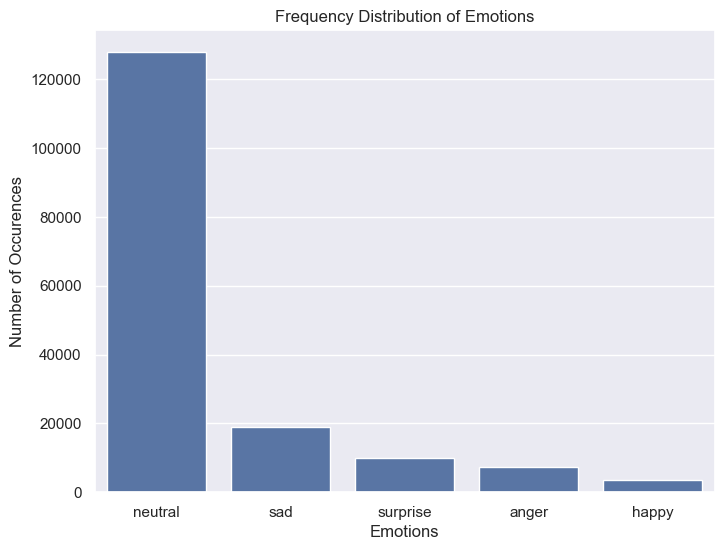

In [21]:
# Distribuição das emoções
emotions_count = data['emotion'].value_counts()
emotions = list(data['emotion'].unique())

# Plot da distribuição das emoções
for emotion in emotions:
    print(emotion + ": " + str(emotions_count.loc[emotion]) + " (" + str(round((emotions_count.loc[emotion] / data.shape[0]) * 100, 2)) + "%)")

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.barplot(x=emotions_count.index, y=emotions_count.values)
plt.title('Frequency Distribution of Emotions')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

##### Distribuição das Emoções sem 'neutral'

sad: 19026 (47.77%)
anger: 7444 (18.69%)
surprise: 9910 (24.88%)
happy: 3451 (8.66%)


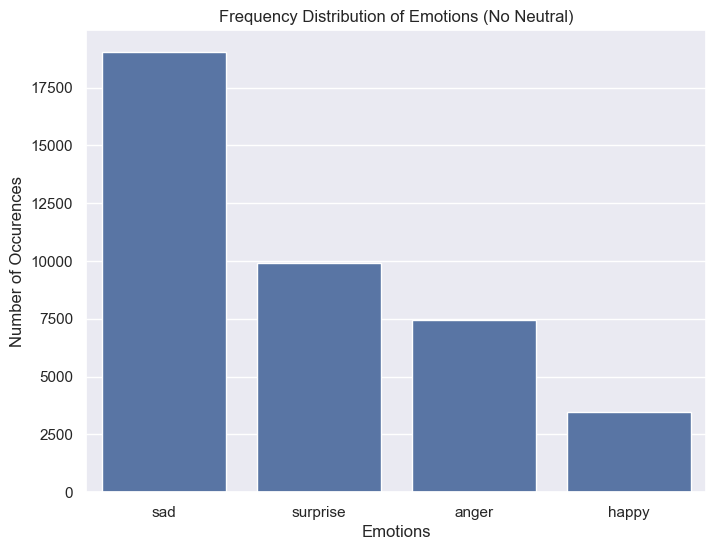

In [22]:
# Isolar o Neutral
data_noNeutral = data.loc[data['emotion'] != 'neutral'].copy()
emotions_count_noNeutral = data_noNeutral['emotion'].value_counts()
emotions_NoNeutral = list(data_noNeutral['emotion'].unique())

# Plot da distribuição das emoções
for emotion in emotions_NoNeutral:
    print(emotion + ": " + str(emotions_count_noNeutral.loc[emotion]) + " (" + str(round((emotions_count_noNeutral.loc[emotion] / data_noNeutral.shape[0]) * 100, 2)) + "%)")

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.barplot(x=emotions_count_noNeutral.index, y=emotions_count_noNeutral.values)
plt.title('Frequency Distribution of Emotions (No Neutral)')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()


### Distribuição das Emoções quando "engaged"

neutral: 113894 (78.3%)
sad: 14279 (9.82%)
anger: 6524 (4.48%)
surprise: 7842 (5.39%)
happy: 2924 (2.01%)


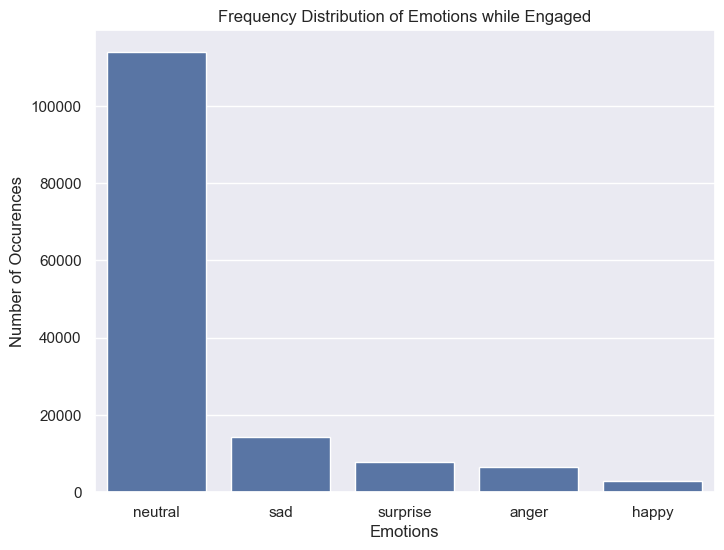

In [23]:
# Dataframe apenas com valores 'engaged'
data_Engaged = data.loc[data['engaged'] == 'yes'].copy()
emotions_count_Engaged = data_Engaged['emotion'].value_counts()
emotions_Engaged = list(data_Engaged['emotion'].unique())

# Plot da distribuição das emoções
for emotion in emotions_Engaged:
    print(emotion + ": " + str(emotions_count_Engaged.loc[emotion]) + " (" + str(round((emotions_count_Engaged.loc[emotion] / data_Engaged.shape[0]) * 100, 2)) + "%)")

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.barplot(x=emotions_count_Engaged.index, y=emotions_count_Engaged.values)
plt.title('Frequency Distribution of Emotions while Engaged')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()


##### Distribuição das Emoções quando "engaged" sem 'neutral'

sad: 14279 (45.23%)
anger: 6524 (20.67%)
surprise: 7842 (24.84%)
happy: 2924 (9.26%)


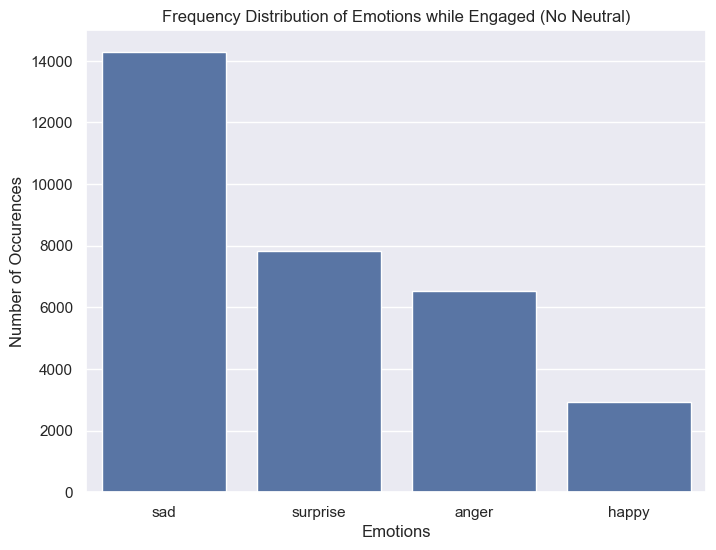

In [24]:
# Dataframe apenas com valores 'engaged'
data_Engaged_noNeutral = data_Engaged.loc[data['emotion'] != 'neutral'].copy()
emotions_count_Engaged_noNeutral = data_Engaged_noNeutral['emotion'].value_counts()
emotions_Engaged_noNeutral = list(data_Engaged_noNeutral['emotion'].unique())

# Plot da distribuição das emoções
for emotion in emotions_Engaged_noNeutral:
    print(emotion + ": " + str(emotions_count_Engaged_noNeutral.loc[emotion]) + " (" + str(round((emotions_count_Engaged_noNeutral.loc[emotion] / data_Engaged_noNeutral.shape[0]) * 100, 2)) + "%)")

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.barplot(x=emotions_count_Engaged_noNeutral.index, y=emotions_count_Engaged_noNeutral.values)
plt.title('Frequency Distribution of Emotions while Engaged (No Neutral)')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()


## Diferentes Emoções a cada 5 minutos enquanto Engaged

##### Com 'neutral'

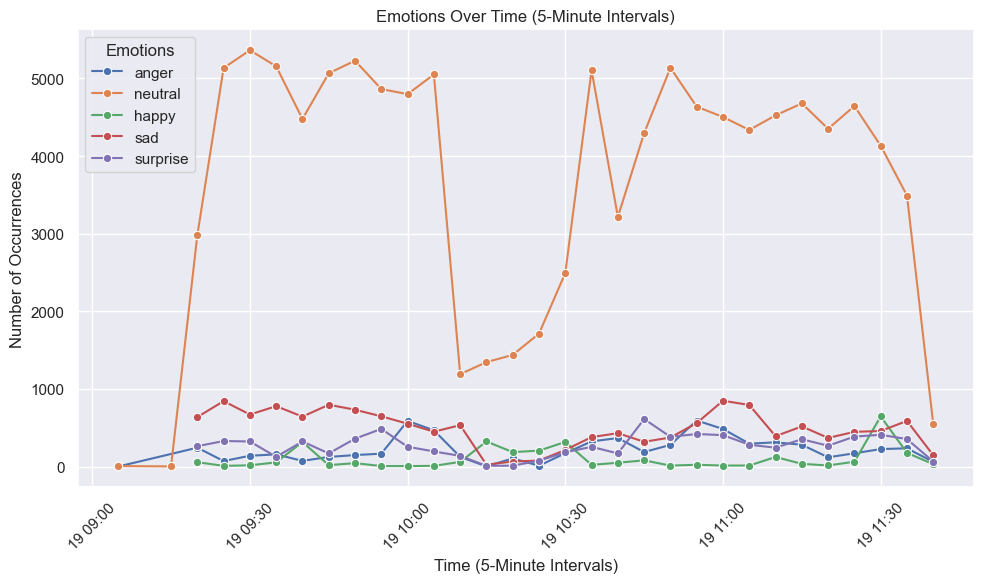

In [25]:
# Numero de ocorrências de emoções a cada 5 minutos
data_Engaged['5min'] = data_Engaged['time'].dt.floor('5min')

# Agrupar por intervalo de tempo de 5 minutos e emoção
emotions_count_5min = data_Engaged.groupby([data_Engaged['5min'], data_Engaged['emotion']]).size().reset_index(name='counts')

plt.figure(figsize=(10, 6))
sns.lineplot(data=emotions_count_5min, x='5min', y='counts', hue='emotion', marker="o")
plt.title('Emotions Over Time (5-Minute Intervals)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Emotions')
plt.tight_layout()
plt.show()


##### Sem 'neutral'

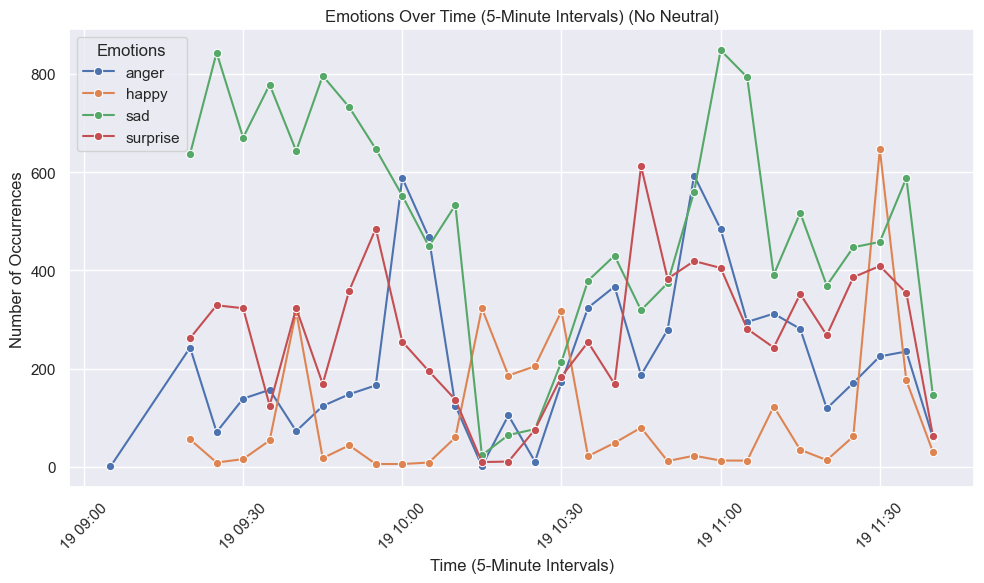

In [26]:
# Numero de ocorrências de emoções a cada 5 minutos
data_Engaged_noNeutral['5min'] = data_Engaged_noNeutral['time'].dt.floor('5min')

# Agrupar por intervalo de tempo de 5 minutos e emoção
emotions_count_5min_noNeutral = data_Engaged_noNeutral.groupby([data_Engaged_noNeutral['5min'], data_Engaged_noNeutral['emotion']]).size().reset_index(name='counts')

plt.figure(figsize=(10, 6))
sns.lineplot(data=emotions_count_5min_noNeutral, x='5min', y='counts', hue='emotion', marker="o")
plt.title('Emotions Over Time (5-Minute Intervals) (No Neutral)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Emotions')
plt.tight_layout()
plt.show()

## Distribuição de Engaged a cada 5 minutos

                       5min engaged  counts
0 2024-09-19 09:05:00+00:00     yes       7
1 2024-09-19 09:15:00+00:00     yes       2
2 2024-09-19 09:20:00+00:00      no     555
3 2024-09-19 09:20:00+00:00     yes    4179
4 2024-09-19 09:25:00+00:00      no     596


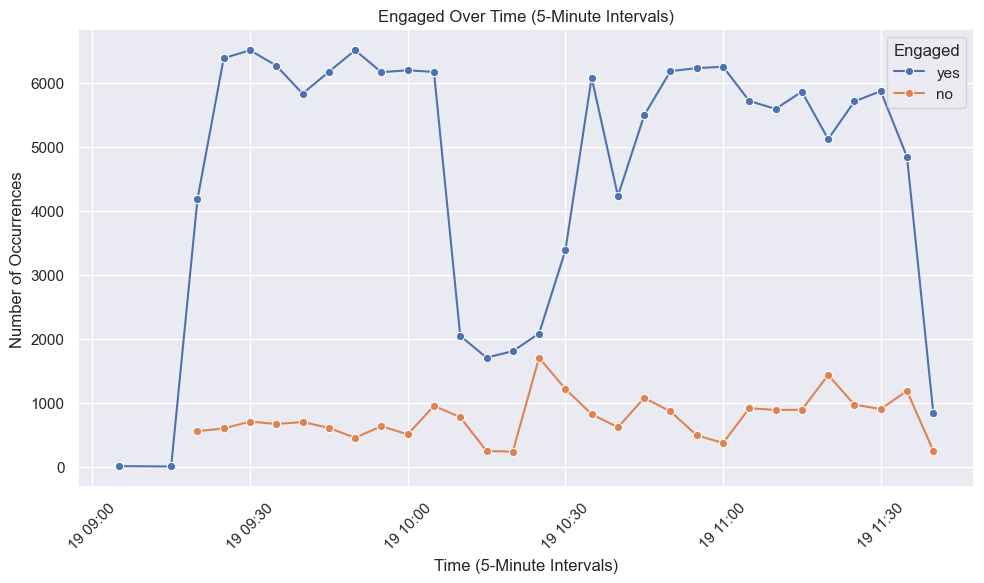

In [29]:
# Para conseguir representar o 'yes' and 'no' agrupa-se por intervalo de tempo de 5 minutos e engagement
data['5min'] = data['time'].dt.floor('5min')
engaged_count_5min = data.groupby([data['5min'], data['engaged']]).size().reset_index(name='counts')


plt.figure(figsize=(10, 6))
sns.lineplot(data=engaged_count_5min, x='5min', y='counts', hue='engaged', marker="o")
plt.title('Engaged Over Time (5-Minute Intervals)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Engaged')
plt.tight_layout()
plt.show()

## Identificação Manual

#### Câmara de cima ('source' == 1)

In [ ]:
# Variáveis globais
imagem = "" # Definir nome da imagem a ser carregada
ref_point = []
areas = []
current_area = []
pessoa_camara1 = {}  # Dicionário para armazenar as áreas com identificadores como Pessoa1, Pessoa2, etc.
pessoa_id = 1       # Contador para nomear as pessoas

# Função de callback para desenhar retângulos ou áreas na imagem
def draw_area(event, x, y, flags, param):
    global ref_point, current_area, pessoa_id
    
    # Registrar ponto inicial
    if event == cv2.EVENT_LBUTTONDOWN:
        ref_point = [(x, y)]
        
    # Registrar ponto final e desenhar o retângulo/área
    elif event == cv2.EVENT_LBUTTONUP:
        ref_point.append((x, y))
        current_area = [(ref_point[0][0], ref_point[0][1]), (x, y)]
        areas.append(current_area)
        
        # Desenhar o retângulo/área no frame
        cv2.rectangle(image, ref_point[0], ref_point[1], (0, 255, 0), 2)
        cv2.imshow("image", image)
        
        # Adicionar ao dicionário com um nome único (Pessoa1, Pessoa2, etc.)
        key = f"Pessoa{pessoa_id}"
        pessoa_camara1[key] = (ref_point[0][0], ref_point[0][1], x, y)
        pessoa_id += 1  # Incrementar o ID para a próxima pessoa


image = cv2.imread(imagem)
clone = image.copy()

# Configurar janela e callback
cv2.namedWindow("image")
cv2.setMouseCallback("image", draw_area)

# Loop para interagir com a imagem
while True:
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
    
    # Se pressionar 'r', resetar a imagem
    if key == ord("r"):
        image = clone.copy()
        areas = []
        pessoa_camara1    = {}  # Limpar o dicionário também
        pessoa_id = 1       # Resetar o contador
    
    # Se pressionar 'q', sair
    elif key == ord("q"):
        break

# Fechar janelas do OpenCV
cv2.destroyAllWindows()

# Mostrar o dicionário com as áreas mapeadas
print("Áreas mapeadas:", pessoa_camara1)

#### Câmara de baixo ('source' == 0)

In [ ]:
# Variáveis globais
imagem = ""     # Definir nome da imagem a ser carregada
ref_point = []
areas = []
current_area = []
pessoa_camara0 = {}  # Dicionário para armazenar as áreas com identificadores como Pessoa1, Pessoa2, etc.
pessoa_id = 1       # Contador para nomear as pessoas

# Função de callback para desenhar retângulos ou áreas na imagem
def draw_area(event, x, y, flags, param):
    global ref_point, current_area, pessoa_id
    
    # Registar ponto inicial
    if event == cv2.EVENT_LBUTTONDOWN:
        ref_point = [(x, y)]
        
    # Registar ponto final e desenhar o retângulo/área
    elif event == cv2.EVENT_LBUTTONUP:
        ref_point.append((x, y))
        current_area = [(ref_point[0][0], ref_point[0][1]), (x, y)]
        areas.append(current_area)
        
        # Desenhar o retângulo/área no frame
        cv2.rectangle(image, ref_point[0], ref_point[1], (0, 255, 0), 2)
        cv2.imshow("image", image)
        
        # Adicionar ao dicionário com um nome único
        key = f"Pessoa{pessoa_id}"
        pessoa_camara0[key] = (ref_point[0][0], ref_point[0][1], x, y)
        pessoa_id += 1  # Incrementar o ID para a próxima pessoa


image = cv2.imread(imagem)
clone = image.copy()

# Configurar janela e callback
cv2.namedWindow("image")
cv2.setMouseCallback("image", draw_area)

# Loop para interagir com a imagem
while True:
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
    
    # Se pressionar 'r', resetar a imagem
    if key == ord("r"):
        image = clone.copy()
        areas = []
        pessoa_camara0 = {}  # Limpar o dicionário também
        pessoa_id = 1       # Resetar o contador
    
    # Se pressionar 'q', sair
    elif key == ord("q"):
        break

# Fechar janelas do OpenCV
cv2.destroyAllWindows()

# Mostrar o dicionário com as áreas mapeadas
print("Áreas mapeadas:", pessoa_camara0)

## K-Means & K-Medoids

In [ ]:
kmeans = False
kmedoids = False

## K-Means 

O K-means é um algoritmo mais leve e utiliza centroids, como como centro dos clusters, que são calculados como a média das posições dos pontos de cada cluster.
É mais sensível a outliers porque a média pode ser deslocada por valores extremos.

##### Câmara de cima ('source' == 1)

In [ ]:
if kmeans:

    # Adicionar as coordenadas x e y da face ao dataframe (devido ao K-Means)
    # Copiar apenas os dados da câmara superior
    data1 = data.loc[data['source'] == 1].copy()
    data1[['face_x', 'face_y']] = pd.DataFrame(data['face'].tolist(), index=data.index)
    data1[['face_x1', 'face_y1']] = pd.DataFrame(data['face'].tolist(), index=data.index)

    print(data1.head(2))

    # Escolha de variáveis para o agrupamento (dando mais peso às coordenadas no referêncial)
    features = ['age', 'race', 'face_x' 'face_y', 'gender']

    # Pré-processamento: OneHotEncoding para variáveis categóricas e normalização para numéricas
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'face_x', 'face_y']),  # Normaliza as variáveis numéricas
        ('cat', OneHotEncoder(), ['gender', 'race'])  # One-hot encoding para categóricas
    ])

    # Pipeline com pré-processamento e K-Means
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('cluster', KMeans(n_clusters=11, random_state=42))
    ])

    # Aplicar o K-Means
    pipeline.fit(data1[features])

    # Atribuir os clusters ao dataframe original
    data1['cluster'] = pipeline['cluster'].labels_

    # Extrair os centroids dos clusters (X, Y) 
    cluster_centers = pd.DataFrame(pipeline['cluster'].cluster_centers_, columns=['head_x_centroid', 'head_y_centroid'])

    # Adicionar o identificador do cluster para os centróides
    cluster_centers['cluster'] = range(len(cluster_centers))

    # Juntar as coordenadas do centroid com o dataframe original
    data1 = data1.merge(cluster_centers[['cluster', 'head_x_centroid', 'head_y_centroid']], on='cluster')

    # Mostrar os resultados
    print(data1.head(2))


##### Câmara de baixo ('source' == 0)

In [ ]:
if kmeans:

    # Adicionar as coordenadas x e y da face ao dataframe (devido ao K-Means)
    # Copiar apenas os dados da câmara superior
    data0 = data.loc[data['source'] == 0].copy()
    data0[['face_x', 'face_y']] = pd.DataFrame(data['face'].tolist(), index=data.index)
    data0[['face_x1', 'face_y1']] = pd.DataFrame(data['face'].tolist(), index=data.index)

    print(data0.head(2))

    # Escolha de variáveis para o agrupamento (dando mais peso às coordenadas no referêncial)
    features = ['age', 'race', 'face_x', 'face_y', 'gender']

    # Pré-processamento: OneHotEncoding para variáveis categóricas e normalização para numéricas
    preprocessor = ColumnTransformer(
    transformers=[
            ('num', StandardScaler(), ['age', 'face_x', 'face_y']),  # Normaliza as variáveis numéricas
            ('cat', OneHotEncoder(), ['gender', 'race'])  # One-hot encoding para categóricas
        ])

    # Pipeline com pré-processamento e K-Means
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('cluster', KMeans(n_clusters=11, random_state=42))
    ])

    # Aplicar o K-Means
    pipeline.fit(data0[features])

    # Atribuir os clusters ao dataframe original
    data0['cluster'] = pipeline['cluster'].labels_

    # Extrair os centroids dos clusters (X, Y, Z) 
    cluster_centers = pd.DataFrame(pipeline['cluster'].cluster_centers_, columns=['head_x_centroid', 'head_y_centroid'])

    # Adicionar o identificador do cluster para os centróides
    cluster_centers['cluster'] = range(len(cluster_centers))

    # Juntar as coordenadas do centroid com o dataframe original
    data0 = data0.merge(cluster_centers[['cluster', 'head_x_centroid', 'head_y_centroid']], on='cluster')

    # Mostrar os resultados
    print(data0.head(2))

## K-Medoids 

O K-medoids é mais complexo e computacionalmente mais pesado, utiliza medoids, que são pontos reais dos dados que minimizam a soma das distâncias para outros pontos dentro do cluster.
É mais robusto a outliers.

##### Câmara de cima ('source' == 1)

In [ ]:
if kmedoids:

    # Adicionar as coordenadas x e y da face ao dataframe (devido ao K-Medoids)
    # Copiar apenas os dados da câmara superior
    data1 = data.loc[data['source'] == 1].copy()
    data1[['face_x', 'face_y']] = pd.DataFrame(data['face'].tolist(), index=data.index)
    data1[['face_x1', 'face_y1']] = pd.DataFrame(data['face'].tolist(), index=data.index)

    print(data1.head(2))

    # Escolha de variáveis para o agrupamento
    features = ['age', 'race', 'face_x', 'face_y', 'gender']


    # Pré-processamento: OneHotEncoding para variáveis categóricas e normalização para numéricas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['age', 'face_x', 'face_y']),
            ('cat', OneHotEncoder(), ['gender', 'race'])
        ])

    # Pipeline com pré-processamento e K-Medoids
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('cluster', KMedoids(n_clusters=9, random_state=42))
    ])

    # Aplicar o K-Medoids
    pipeline.fit(data1[features])

    # Atribuir os clusters ao dataframe original
    data1['cluster'] = pipeline['cluster'].labels_

    print(data1.head(2))

##### Câmara de baixo ('source' == 0)

In [ ]:
if kmedoids:

    # Adicionar as coordenadas x e y da face ao dataframe (devido ao K-Medoids)
    # Copiar apenas os dados da câmara superior
    data0 = data.loc[data['source'] == 0].copy()
    data0[['face_x', 'face_y']] = pd.DataFrame(data['face'].tolist(), index=data.index)
    data0[['face_x1', 'face_y1']] = pd.DataFrame(data['face'].tolist(), index=data.index)

    print(data0.head(2))


    # Escolha de variáveis para o agrupamento
    features = ['age', 'race', 'face_x', 'face_y', 'gender']


    # Pré-processamento: OneHotEncoding para variáveis categóricas e normalização para numéricas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['age', 'face_x', 'face_y']),
            ('cat', OneHotEncoder(), ['gender', 'race'])
        ])

    # Pipeline com pré-processamento e K-Medoids
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('cluster', KMedoids(n_clusters=9, random_state=42))
    ])

    # Aplicar o K-Medoids
    pipeline.fit(data0[features])

    # Atribuir os clusters ao dataframe original
    data0['cluster'] = pipeline['cluster'].labels_

    print(data0.head(2))

### Mostrar Clusters no Mapa

##### Câmara de cima ('source' == 1)

In [ ]:
# Ver os clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data1['face_x'], data0['face_y'], c=data0['cluster'], cmap='viridis', alpha=0.7)
plt.title('Clusters of Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.gca().invert_yaxis()  # Inverter o eixo y
plt.show()

##### Câmara de baixo ('source' == 0)

In [ ]:
# Ver os clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data0['face_x'], data0['face_y'], c=data0['cluster'], cmap='viridis', alpha=0.7)
plt.title('Clusters of Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.gca().invert_yaxis()  # Inverter o eixo y
plt.show()

### Unir os 2 dataframes das duas câmaras

In [117]:
# Substituição câmera de baixo
#data0['cluster'] = data0['cluster'].replace(6,260)


# Subsituição câmara de cima
#data1['cluster'] = data1['cluster'].replace(10,260)


#data_final = pd.concat([data0,data1], ignore_index=True)
data_final = data.copy()    # Não foi feito o agrupamento (apenas temporariamente)

## Distribuição de Engagement de cada pessoa

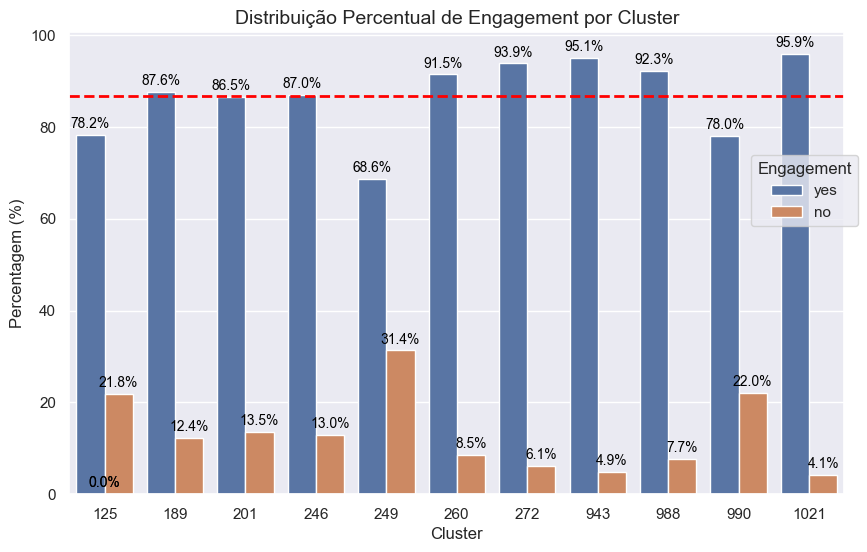

In [118]:
# Agrupar por cluster e engajamento, contando as ocorrências
group_cluster_engagment = data_final.groupby(['cluster', 'engaged']).size().reset_index(name='contagem')

# Calcular a percentagem de cada engajamento dentro de cada cluster
group_cluster_engagment['percentagem'] = group_cluster_engagment.groupby('cluster')['contagem'].transform(lambda x: x / x.sum() * 100)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='percentagem', hue='engaged', data=group_cluster_engagment,hue_order=['yes', 'no'])

# Adicionar os valores da percentagem em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='baseline', 
                fontsize=10, color='black', 
                xytext=(0, 5),  # Deslocamento em relação à barra
                textcoords='offset points')

# Média de engagement (fazer valor automaticamente !!!!!)
plt.axhline(86.78, color='red', linestyle='--', linewidth=2)

# Definir os títulos e rótulos
plt.title('Percentage Distribution of Engagement by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Engagement', bbox_to_anchor=(0.87, 0.75))

# Mostrar o gráfico
plt.show()


## Distribuição de Emotions de cada pessoa

In [ ]:
# Agrupar por cluster e emoção, contando as ocorrências
group_cluster_emotion = data_final.groupby(['cluster', 'emotion']).size().reset_index(name='contagem')

# Calcular a percentagem de cada emoção dentro de cada cluster
group_cluster_emotion['percentagem'] = group_cluster_emotion.groupby('cluster')['contagem'].transform(lambda x: x / x.sum() * 100)


# Criar uma tabela pivot, onde as linhas são clusters, colunas são emoções e os valores são percentagens
tabela_emocoes = group_cluster_emotion.pivot(index='cluster', columns='emotion', values='percentagem')
cmap_custom = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#A9A9A9", "#DCDCDC", "#B0C4DE", "#A9A0A9"])
table = tabela_emocoes.style.format("{:.2f}%") \
    .background_gradient(cmap=cmap_custom, axis=1) \
    .set_table_styles([{'selector': 'thead th', 
                        'props': [('background-color', '#4F4F4F'),  # Cinza escuro no cabeçalho
                                  ('color', 'white'),
                                  ('font-size', '12px')]}]) \
    .set_properties(**{'border': '1px solid black', 'color': 'black', 'font-size': '10pt'}) \
    .set_caption("Percentage Distribution of Emotions by Cluster")

display(table)

## Engagement Fila da Frente

In [ ]:
# Copiar o DataFrame original
data_fila_frente = data_final.copy()
clusters_fila_frente = []    # Lista de clusters que estão na fila da frente (Definir manualmente)

data_fila_frente = data_fila_frente[data_fila_frente['cluster'].isin(clusters_fila_frente)]

engagement_count_fila_frente = data_fila_frente['engaged'].value_counts()

# Plot da distribuição do Engagement
print("Engaged: " + str(engagement_count_fila_frente.iloc[0]) + " (" + str(round((engagement_count_fila_frente.iloc[0] / data_fila_frente.shape[0]) * 100, 2)) + "%)")
print("Not Engaged: " + str(engagement_count_fila_frente.iloc[1]) + " (" + str(round((engagement_count_fila_frente.iloc[1] / data_fila_frente.shape[0]) * 100, 2)) + "%)")

# Distribuição das emoções
sns.set_theme(style="darkgrid")
sns.barplot(x=engagement_count_fila_frente.index, y=engagement_count_fila_frente.values)
plt.title('Frequency Distribution of Engaged')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Engagement', fontsize=12)
plt.show()




## Engagement Fila de Trás

In [ ]:
# Copiar o DataFrame original
data_fila_tras = data_final.copy()
clusters_fila_tras = []    # Lista de clusters que estão na fila de trás (Definir manualmente)

data_fila_tras = data_fila_tras[data_fila_tras['cluster'].isin(clusters_fila_tras)]

engagement_count_fila_tras = data_fila_tras['engaged'].value_counts()

# Plot da distribuição do Engagement
print("Engaged: " + str(engagement_count_fila_tras.iloc[0]) + " (" + str(round((engagement_count_fila_tras.iloc[0] / data_fila_tras.shape[0]) * 100, 2)) + "%)")
print("Not Engaged: " + str(engagement_count_fila_tras.iloc[1]) + " (" + str(round((engagement_count_fila_tras.iloc[1] / data_fila_tras.shape[0]) * 100, 2)) + "%)")

# Distribuição das emoções
sns.set_theme(style="darkgrid")
sns.barplot(x=engagement_count_fila_tras.index, y=engagement_count_fila_tras.values)
plt.title('Frequency Distribution of Engaged')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Engagement', fontsize=12)
plt.show()

## Engagement Meio

In [ ]:
# Copiar o DataFrame original
data_meio = data_final.copy()
clusters_meio = []    # Lista de clusters que estão no meio (Definir manualmente)

data_meio = data_meio[data_meio['cluster'].isin(clusters_meio)]

engagement_count_meio = data_meio['engaged'].value_counts()

# Plot da distribuição do Engagement
print("Engaged: " + str(engagement_count_meio.iloc[0]) + " (" + str(round((engagement_count_meio.iloc[0] / data_meio.shape[0]) * 100, 2)) + "%)")
print("Not Engaged: " + str(engagement_count_meio.iloc[1]) + " (" + str(round((engagement_count_meio.iloc[1] / data_meio.shape[0]) * 100, 2)) + "%)")

# Distribuição das emoções
sns.set_theme(style="darkgrid")
sns.barplot(x=engagement_count_meio.index, y=engagement_count_meio.values)
plt.title('Frequency Distribution of Engaged')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Engagement', fontsize=12)
plt.show()

## Engagement Lados

In [ ]:
# Copiar o DataFrame original
data_lado = data_final.copy()
clusters_lado = []    # Lista de clusters que estão nas laterais (Definir manualmente)

data_lado = data_lado[data_lado['cluster'].isin(clusters_lado)]

engagement_count_lado = data_lado['engaged'].value_counts()

# Plot da distribuição do Engagement
print("Engaged: " + str(engagement_count_lado.iloc[0]) + " (" + str(round((engagement_count_lado.iloc[0] / data_lado.shape[0]) * 100, 2)) + "%)")
print("Not Engaged: " + str(engagement_count_lado.iloc[1]) + " (" + str(round((engagement_count_lado.iloc[1] / data_lado.shape[0]) * 100, 2)) + "%)")

# Distribuição das emoções
sns.set_theme(style="darkgrid")
sns.barplot(x=engagement_count_lado.index, y=engagement_count_lado.values)
plt.title('Frequency Distribution of Engaged')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Engagement', fontsize=12)
plt.show()

## Engagement de cada pessoa a cada 5 minutos

In [ ]:
clusters = data_final['cluster'].unique()

for i in clusters:
    # Dataframe com dados do cluster especifico
    data_cluster_i = data_final[data_final['cluster'] == i]
    group_cluster_time =  data_cluster_i.groupby([data_cluster_i['5min'], data_cluster_i['engaged']]).size().reset_index(name='counts')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=group_cluster_time, x='5min', y='counts', hue='engaged', marker="o")
    plt.title(f'Engaged Over Time (5-Minute Intervals) - Cluster {i}')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Engaged')
    plt.tight_layout()
    plt.show()


## Emotions de cada pessoa a cada 5 minutos

In [ ]:
for i in clusters:
    # Dataframe com dados do cluster especifico
    data_cluster_i = data_final[data_final['cluster'] == i]
    group_cluster_time =  data_cluster_i.groupby([data_cluster_i['5min'], data_cluster_i['emotion']]).size().reset_index(name='counts')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=group_cluster_time, x='5min', y='counts', hue='emotion', marker="o")
    plt.title(f'Emotions Over Time (5-Minute Intervals) - Cluster {i}')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Engaged')
    plt.tight_layout()
    plt.show()

## Engagement de cada pessoa a cada 5 minutos relativamente ao padrão

In [30]:
# Agrupar por '5min' e somar as contagens de 'yes' e 'no'
total_counts = engaged_count_5min.groupby('5min')['counts'].sum().reset_index(name='total_counts')

# Adicionar a coluna 'total_counts' ao dataframe 'engaged_count_5min'
engaged_count_5min_total = pd.merge(engaged_count_5min, total_counts, on='5min')

# Selecionar apenas os valores que estão "engaged"
engaged_count_5min_total = engaged_count_5min_total[engaged_count_5min_total['engaged'] == "yes"]

# Normalizar as contagens do gráfico geral
engaged_count_5min_total['normalized_counts'] = engaged_count_5min_total['counts'] / engaged_count_5min_total['total_counts']

# Obter os clusters únicos
clusters = data_final['cluster'].unique()

# Criar um gráfico para cada cluster
for i in clusters:
    # Dataframe com dados do cluster específico
    data_cluster_i = data_final[data_final['cluster'] == i]
    total_counts = data_cluster_i.groupby([data_final['5min'], data_final['engaged']]).size().reset_index(name='counts')

    total_counts_1 = total_counts.groupby('5min')['counts'].sum().reset_index(name='total_counts')
    mergeTOP = pd.merge(total_counts_1, total_counts, on='5min')
    mergeTOP = mergeTOP[mergeTOP['engaged'] != "no"]
    mergeTOP['normalized_counts'] = mergeTOP['counts'] / mergeTOP['total_counts'] 

    # Criar um gráfico novo para cada cluster
    plt.figure(figsize=(10, 6))
    
    # Plotar o gráfico geral em um tom mais claro
    sns.lineplot(data=engaged_count_5min_total, x='5min', y='normalized_counts', hue='engaged', alpha=0.3, marker="o", linestyle='--', linewidth=1, legend=False)
    
    # Plotar o gráfico do cluster em um tom mais forte
    sns.lineplot(data=mergeTOP, x='5min', y='normalized_counts', hue='engaged', marker="o", linewidth=2)

    # Configurações dos eixos e título
    plt.title(f'Engaged Over Time (5-Minute Intervals) - Cluster {i}', fontsize=14)
    plt.ylabel('Normalized Number of Occurrences', fontsize=12)
    plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Engaged')
    plt.tight_layout()
    
    # Mostrar o gráfico para o cluster específico
    plt.show()



## Variação do movimento da face nos últimos 5 segundos

In [ ]:
for i in clusters:
    data_cluster_i = data_final[data_final['cluster'] == i]
    # Calcular a distância Euclidiana entre a posição atual e o centróide do cluster
    data_cluster_i['dist_X'] = (data_cluster_i['face_x'] - data_cluster_i['head_x_centroid']) ** 2
    data_cluster_i['dist_Y'] = (data_cluster_i['face_y'] - data_cluster_i['head_y_centroid']) ** 2
    ## data_cluster_i['dist'] = np.sqrt(data_cluster_i['dist_X'] + data_cluster_i['dist_Y'])    

    


     
    